In [80]:
import os,sys,signal, copy
import math
from contextlib import contextmanager

import pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
import matplotlib.ticker as ticker
from matplotlib.animation import ArtistAnimation

from scipy.fftpack import fft
from scipy.signal.windows import hann

import musicnetRaven as musicnet

from time import time

sys.path.insert(0,'lib/')
import config
import diagnosticsP3
# import base_model

from sklearn.metrics import average_precision_score

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='3'

import torch
from torch.nn.functional import conv1d, mse_loss
from torchcontrib.optim import SWA

from tqdm import tqdm
import mir_eval

from IPython.display import Audio

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [81]:
# function for returning scientific notation in a plot
def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return fr'${a} \times 10^{{{b}}}$'

In [82]:
# lvl1 convolutions are shared between regions
m = 128
k = 500              # lvl1 nodes
n_fft = 4096              # lvl1 receptive field
window = 16384 # total number of audio samples?
stride = 512
batch_size = 500
regions = 1 + (window - n_fft)//stride

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers
kwargs = {'num_workers': 15, 'pin_memory': True, 'worker_init_fn': worker_init}

In [83]:
start = time()
root = '../data/'
test_set = musicnet.MusicNet(root=root, train=False, download=True, refresh_cache=False, window=window, epoch_size=50000, mmap=False)
print("Time used = ", time()-start)

Time used =  0.3720564842224121


In [84]:
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

In [85]:
def create_filters(n_fft, freq_bins=None, low=50,high=6000, mode="stft"):
    if freq_bins==None:
        freq_bins = n_fft//2+1
    
    s = np.arange(0, n_fft, 1)
    wsin = np.empty((freq_bins,1,n_fft), dtype=np.float32)
    wcos = np.empty((freq_bins,1,n_fft), dtype=np.float32)
    start_freq = low
    end_freq = high
    # num_cycles = start_freq*d/44000.
    # scaling_ind = np.log(end_freq/start_freq)/k
    
    if mode=="fft":
        window_mask = 1
    elif mode=="stft":
        window_mask = hann(n_fft, sym=False) # same as 0.5-0.5*np.cos(2*np.pi*x/(k))
    else:
        raise Exception("Unknown mode, please chooes either \"stft\" or \"fft\"")
        

    for k in range(freq_bins): # Only half of the bins contain useful info
        wsin[k,0,:] = window_mask*np.sin(2*np.pi*k*s/n_fft)
        wcos[k,0,:] = window_mask*np.cos(2*np.pi*k*s/n_fft)
    
    return wsin,wcos

def create_filtersv2(n_fft, freq_bins=None, low=50,high=6000, mode="fft"):
    if freq_bins==None:
        freq_bins = n_fft//2+1
    
    s = torch.arange(0, n_fft, 1.)
    wsin = torch.empty((freq_bins,1,n_fft))
    wcos = torch.empty((freq_bins,1,n_fft))
    start_freq = low
    end_freq = high
    # num_cycles = start_freq*d/44000.
    # scaling_ind = np.log(end_freq/start_freq)/k
    
    if mode=="fft":
        window_mask = 1
    elif mode=="stft":
        window_mask = 0.5-0.5*torch.cos(2*math.pi*s/(n_fft)) # same as hann(n_fft, sym=False)
    else:
        raise Exception("Unknown mode, please chooes either \"stft\" or \"fft\"")
        

    for k in range(freq_bins): # Only half of the bins contain useful info
        wsin[k,0,:] = window_mask*torch.sin(2*math.pi*k*s/n_fft)
        wcos[k,0,:] = window_mask*torch.cos(2*math.pi*k*s/n_fft)
    
    return wsin,wcos


In [7]:
Loss = torch.nn.MSELoss()
def L(yhatvar,y):
    return Loss(yhatvar,y) * 128/2

In [86]:
class Model(torch.nn.Module):
    def __init__(self, avg=.9998):
        super(Model, self).__init__()
        # Create filter windows
        wsin, wcos = create_filtersv2(n_fft,k, mode="stft")
        with torch.cuda.device(0):
            self.wsin = torch.Tensor(wsin).cuda()
            self.wcos = torch.Tensor(wcos).cuda()
            
        # Creating Layers
        self.linear = torch.nn.Linear(regions*k, m)
        torch.nn.init.constant_(self.linear.weight, 0) # initialize
        
        self.avg = avg
        #Create a container for weight average
        self.averages = copy.deepcopy(list(parm.cuda().data for parm in self.parameters())) 

        
    def forward(self,x):
        zx = conv1d(x[:,None,:], self.wsin, stride=stride).pow(2) \
           + conv1d(x[:,None,:], self.wcos, stride=stride).pow(2)
        return torch.log(zx + 10e-8)
    
    def average_iterates(self):
        for parm, pavg in zip(self.parameters(), self.averages):
            pavg.mul_(self.avg).add_(1.-self.avg, parm.data) # 0.9W_avg + 0.1W_this_ite
    
    
@contextmanager
def averages(model):
    orig_parms = copy.deepcopy(list(parm.data for parm in model.parameters()))
    for parm, pavg in zip(model.parameters(), model.averages):
        parm.data.copy_(pavg)
    yield
    for parm, orig in zip(model.parameters(), orig_parms):
        parm.data.copy_(orig)

# Averaged Weights

In [87]:
model = Model()
model.cuda()

Model(
  (linear): Linear(in_features=12500, out_features=128, bias=True)
)

In [88]:
test_set.rec_ids

[2556, 2303, 2382, 2416, 2191, 2298, 2106, 2628, 1819, 1759]

In [89]:
with test_set:
    X, Y = test_set.access(2303, 50000)
Audio(X, rate=44100)    

In [90]:
X = torch.tensor(X.reshape(1,-1)).cuda()

In [94]:
X.shape

torch.Size([1, 16384])

In [95]:
Y.shape

(128,)

In [91]:
X_Spec = model(X)

(-0.5, 0.5, -0.5, 12499.5)

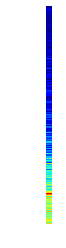

In [114]:
plt.imshow(X_Spec.view(-1,1).cpu(), aspect=0.003, cmap='jet', origin='lower')
# plt.colorbar()
# plt.xlabel('time step')
# plt.ylabel('frequency bin')
plt.axis('off')

In [22]:
song = test_set.records

In [ ]:
loss_history_train = []
avgp_history_train = []
loss_history_test = []
avgp_history_test = []
epochs = 20
avg = .9998
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6, momentum=.95)
# optimizer = SWA(base_opt, swa_start=0, swa_freq=1, swa_lr=0.000001)

try:
    with train_set, test_set:
        total_i = len(train_loader)
        print("epoch\ttrain loss\ttest loss\ttrain avg\ttest avg\ttime\tutime")
        for e in range(epochs):
            yground = torch.FloatTensor(batch_size*len(train_loader), m) # what not do this together with loss
            yhat = torch.FloatTensor(batch_size*len(train_loader), m)
            avgp, loss_e = 0.,0
            t = time()
            for i, (x,y) in enumerate(train_loader):
                print(f"{i}/{total_i} batches", end = '\r')
                optimizer.zero_grad()
                
                # making x and y into pytorch dealable format
                x = x.cuda(non_blocking=True)
                y = y.cuda(non_blocking=True)
                yhatvar = model(x)
                loss = L(yhatvar,y)
                loss.backward()
                loss_e += loss.item() #getting the number
                
                yground[i*batch_size:(i+1)*batch_size] = y.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data
                
                optimizer.step()
                model.average_iterates() # Averaging the weights for validation
                
            avgp = average_precision_score(yground.flatten(),yhat.flatten())    
            loss_history_train.append(loss_e/len(train_loader))
            avgp_history_train.append(avgp)   
            t1 = time()
            avgp, loss_e = 0.,0.           
#             optimizer.swap_swa_sgd() # change to average weight
            
            # For testing
            yground = torch.FloatTensor(batch_size*len(test_loader), m) # what not do this together with loss
            yhat = torch.FloatTensor(batch_size*len(test_loader), m)
            
            with averages(model):
                for i, (x_test,y_test) in enumerate(test_loader):
                    x_test = x_test.cuda()
                    y_test = y_test.cuda()
                    yhatvar = model(x_test)
                    loss_e += L(yhatvar, y_test).item() #getting the number

                    yground[i*batch_size:(i+1)*batch_size] = y_test.data
                    yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data
                avgp = average_precision_score(yground.cpu().flatten(),yhat.cpu().flatten())
                loss_history_test.append(loss_e/len(test_loader))
                avgp_history_test.append(avgp)
                print('{}\t{:2f}\t{:2f}\t{:2f}\t{:2f}\t{:2.1f}\t{:2.1f}'.\
                      format(e,
                             loss_history_train[-1],loss_history_test[-1],
                             avgp_history_train[-1],avgp_history_test[-1],
                             time()-t, time()-t1))


        
except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print("Finsihed")
    

epoch	train loss	test loss	train avg	test avg	time	utime
0	1.148502	1.114585	0.393539	0.219537	17.4	5.9
1	0.990497	1.085976	0.542215	0.432743	16.9	5.9
2	0.950101	1.062772	0.575206	0.498464	17.1	5.9
3	0.934080	1.034255	0.591234	0.528024	16.9	5.9
4	0.922177	1.011965	0.602612	0.544076	16.9	5.9
5	0.913953	0.987663	0.608726	0.550918	16.8	5.9
6	0.904188	0.965327	0.615410	0.560971	17.0	6.0
7	0.899934	0.952338	0.619521	0.568790	17.0	5.9
8	0.899629	0.928803	0.621578	0.575316	17.0	6.0
9	0.893411	0.907742	0.625093	0.575423	16.9	5.9
10	0.888432	0.888077	0.629021	0.580116	16.9	5.9
11	0.887846	0.873823	0.630865	0.586730	16.9	5.9
12	0.885385	0.857412	0.631636	0.587660	17.0	5.9
13	0.881181	0.845716	0.635548	0.589597	17.0	5.9
14	0.878955	0.834897	0.635856	0.593850	16.8	5.9
15	0.878635	0.822005	0.636636	0.598700	16.8	5.9


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(loss_history_train)
ax[0].plot(loss_history_test)
ax[0].legend(['train', 'test'])
ax[0].set_title('Loss', size=20)

ax[1].plot(avgp_history_train)
ax[1].plot(avgp_history_test)
ax[1].legend(['train', 'test'])
ax[1].set_title('Accuracy', size=20)

# Mirex stats

In [ ]:
def get_mir_accuracy(Yhat, Y_true, threshold=0.4):
    Yhatlist = []
    Ylist = []
    Yhatpred = Yhat>threshold
    for i in range(len(Yhatpred)):
        print(f"{i}/{len(Yhatpred)} batches", end = '\r')
        fhat = []
        f = []
        for note in range(m):
            if Yhatpred[i][note] == 1:
                fhat.append(440.*2**(((note)-69.)/12.))

            if Y_true[i][note] == 1:
                f.append(440.*2**(((note)-69.)/12.))

        Yhatlist.append(np.array(fhat))
        Ylist.append(np.array(f))
    avp = average_precision_score(Y_true.flatten(),Yhat.detach().cpu().flatten())
    P,R,Acc,Esub,Emiss,Efa,Etot,cP,cR,cAcc,cEsub,cEmiss,cEfa,cEtot = \
    mir_eval.multipitch.metrics(np.arange(len(Ylist))/100.,Ylist,np.arange(len(Yhatlist))/100.,Yhatlist)
    print('{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}'.format(100*avp,100*P,100*R,Acc,Etot,Esub,Emiss,Efa))
    return avp,P,R,Acc,Etot
def get_piano_roll(rec_id, window=16384, stride=1000, offset=44100, count=7500):
    sf=4
    if stride == -1:
        stride = (test_set.records[rec_id][1] - offset - int(sf*window))/(count-1)
        stride = int(stride)
    else:
        count = (test_set.records[rec_id][1] - offset - int(sf*window))/stride + 1
        count = int(count)
        
    X = np.zeros([count, window])
    Y = np.zeros([count, m])    
        
    for i in range(count):
        X[i,:], Y[i] =  test_set.access(rec_id, offset+i*stride)
        
    X = torch.tensor(X).float().cuda()
    Y_pred = model(X)
    
    return Y_pred, Y
    

In [ ]:
print('AvgP\tP\tR\tAcc\tETot\tESub\tEmiss\tEfa')
Accavg = 0
Etotavg = 0
for songid in test_set.rec_ids:
    Y_pred, Y_true = get_piano_roll(songid, stride=-1)
#     Yhatpred = Y_pred > 0.4
    _,_,_,Acc,Etot = get_mir_accuracy(Y_pred, Y_true)
    Accavg += Acc
    Etotavg += Etot

In [ ]:
Accavg = Accavg/len(test_set.rec_ids)

In [ ]:
Etotavg = Etotavg/len(test_set.rec_ids)

In [ ]:
print('Average Accuracy: \t{:2.2f}\nAverage Error: \t\t{:2.2f}'.format(Accavg*100, Etotavg*100))